In [30]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np
import random
import gdown
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.utils import plot_model

In [31]:

def download_read_file_name(file_name, url_raw, users_cols, sep):
  url = "https://drive.google.com/uc?id=" + url_raw.split('/')[-2]     # Do not change
  gdown.download(url, file_name, quiet=False)                          # Name of the file'
  df_file = pd.read_csv(file_name, sep=sep, names=users_cols, encoding='latin-1')
  return df_file 


file_user_geo = "user_geo.csv"
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
sep = '|'
url_raw = "https://drive.google.com/file/d/1cabEkxQ__WWZj-1wXNf7HMkpsxlLPBet/view?usp=sharing"
df_user_geo = download_read_file_name(file_user_geo, url_raw, users_cols, sep)


file_search_hist = "search_hist.csv"
search_cols = ['user', 'search_hist']
sep = '\t'
url_raw = "https://drive.google.com/file/d/1uaUJwlTdKNVYiB1YjzKaCXHkUJsgm4Yv/view?usp=sharing"
df_search = download_read_file_name(file_search_hist, url_raw, search_cols, sep)


file_watch_time = "watch_time.csv"
watch_cols = ['user_id', 'movie_id', 'watch_hist_time']
sep = '\t'
url_raw = "https://drive.google.com/file/d/1ubtgEnfFsI0osUW37PlBLaK3QRkhAQFp/view?usp=sharing"
df_watch = download_read_file_name(file_watch_time, url_raw, watch_cols, sep)




movies_cols = ["movie_id", "title", "release_date", "video_release_date", "imdb_url",
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
]

file_movie = "movie.csv"
sep = '|'
url_raw = "https://drive.google.com/file/d/1OTapEkEjHcQFT03UTLL-5qHW48vNZ8r6/view?usp=sharing"
df_movie = download_read_file_name(file_movie, url_raw, movies_cols, sep)




Downloading...
From: https://drive.google.com/uc?id=1cabEkxQ__WWZj-1wXNf7HMkpsxlLPBet
To: /content/user_geo.csv
100%|██████████| 224/224 [00:00<00:00, 144kB/s]
Downloading...
From: https://drive.google.com/uc?id=1uaUJwlTdKNVYiB1YjzKaCXHkUJsgm4Yv
To: /content/search_hist.csv
100%|██████████| 82.0/82.0 [00:00<00:00, 114kB/s]
Downloading...
From: https://drive.google.com/uc?id=1ubtgEnfFsI0osUW37PlBLaK3QRkhAQFp
To: /content/watch_time.csv
100%|██████████| 165/165 [00:00<00:00, 294kB/s]
Downloading...
From: https://drive.google.com/uc?id=1OTapEkEjHcQFT03UTLL-5qHW48vNZ8r6
To: /content/movie.csv
100%|██████████| 1.30k/1.30k [00:00<00:00, 2.47MB/s]


In [32]:
print(df_search['search_hist'].notnull().sum())

6


In [33]:
df_movie.head(5)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (2011),01-Jan-2011,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (2020),01-Jan-2020,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1998),01-Jan-1998,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1998),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
df_movie["year"] = df_movie['release_date'].apply(lambda x: str(x).split('-')[-1])
df_movie['example_age'] = (pd.to_datetime("now") - pd.to_datetime(df_movie['release_date']))\
            /np.timedelta64(1,'D') 

df_movie.head(5)

# normalize
def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

df_movie = normalize_col(df_movie,'example_age')
df_watch = normalize_col(df_watch,'watch_hist_time')

In [76]:
data_movie_watch = df_watch.merge(df_movie, on='movie_id').merge(df_user_geo, on='user_id')
data_movie_watch['user_id']=data_movie_watch['user_id'].astype(int)
data_movie_watch['movie_id']=data_movie_watch['movie_id'].astype(int)
data_movie_watch = data_movie_watch.set_index(['user_id']).sort_index()
data_movie_watch = data_movie_watch.reset_index()
data_movie_watch['movie_name']=data_movie_watch['title'].str[:-6]

# occupation encoding
occupations = data_movie_watch["occupation"].unique().tolist()
occupations_encoded = {x: i for i, x in enumerate(occupations)}
occupationsencoded2occupations = {i: x for i, x in enumerate(occupations)}

user_ids = data_movie_watch["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = data_movie_watch["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

title_ids = data_movie_watch["title"].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}

data_movie_watch["user"] = data_movie_watch["user_id"].map(user2user_encoded)
data_movie_watch["movie"] = data_movie_watch["movie_id"].map(movie2movie_encoded)
data_movie_watch["title_d"] = data_movie_watch["title"].map(title2title_encoded)
data_movie_watch["occupation"] = data_movie_watch["occupation"].map(occupations_encoded)

search_hists = df_search["search_hist"].unique().tolist()
search_encoded = {x: i for i, x in enumerate(search_hists)}
searchencoded2search = {i: x for i, x in enumerate(search_hists)}


df_search["search_hist"] = df_search["search_hist"].map(search_encoded)
df_search = normalize_col(df_search,'search_hist')


watch_hist = data_movie_watch.groupby(['user'])['movie_id', 'watch_hist_time', 'example_age'].agg(list).reset_index()
search_hist = df_search.groupby(['user'])['search_hist'].apply(list).reset_index()

user_video_list = data_movie_watch.pivot(index='user_id', columns='movie_id', values='movie').reset_index()
user_video_list.fillna(data_movie_watch["movie_id"].max()+1, inplace=True)


df_user_movie_list = pd.merge(watch_hist,search_hist, how='left')

df_user_movie_list['search_hist'] = df_user_movie_list['search_hist'].apply(lambda x: x if type(x) is list else []) # NaN

# label the predict future watch or held-out watch
df_user_movie_list['predict_labels'] = df_user_movie_list['movie_id'].apply(lambda lst: [int(random.uniform(0, data_movie_watch["movie"].max()))]) #label
#df_user_movie_list['predict_labels'] = df_user_movie_list['movie_id'][-1:] #label


max_user = df_user_movie_list.user.count()
print("user_movie_list count: ", max_user)

train_user_bound = int(max_user*0.8)

train_data = df_user_movie_list[(df_user_movie_list.user >= 1)&
                                  (df_user_movie_list.user <= train_user_bound)]
test_data = df_user_movie_list[(df_user_movie_list.user > train_user_bound)&
                                  (df_user_movie_list.user <= max_user)]
#print("train_data: ", train_data.head(5))

print("train_data: ", test_data.head(5))


user_movie_list count:  10
train_data:     user movie_id        watch_hist_time example_age search_hist predict_labels
9     9      [1]  [0.20069923880332802]       [1.0]          []            [3]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


# Candidate generation

In [78]:
EMBEDDING_DIMS = 256  #32， 256
DENSE_UNITS = 256   # 32， 256
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=data_movie_watch["movie_id"].max()+1 # 10 + 1
LEARNING_RATE = 0.01


# Deep Neural Network Model

In [79]:

class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')
l2_norm_1 = L2NormLayer(name='l2_norm_1')



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 watch_hist (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 example_age (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 features_embeddings (Embedding  (None, None, 256)   2816        ['watch_hist[0][0]']             
 )                                                                                                
                                                                                                  
 example_age_embeddings (Embedd  (None, None, 256)   2816        ['example_age[0][0]']      

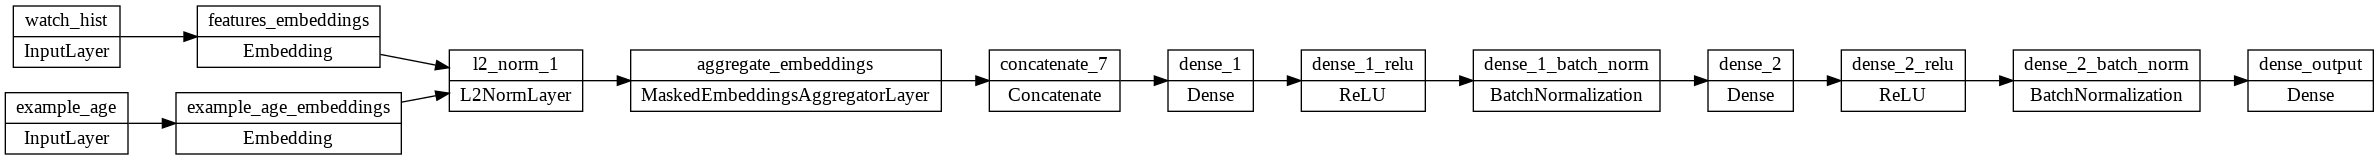

In [80]:
def model_candidate_geneartion():
    # Input layer
    input_watch_hist = tf.keras.Input(shape=(None, ), name='watch_hist')
    input_example_age = tf.keras.Input(shape=(None, ), name='example_age')
    input_search_list = tf.keras.Input(shape=(None, ), name='search_list')

    # Embedding layer 
    features_embedding_layer=Embedding(input_dim=NUM_CLASSES,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='features_embeddings')
    features_embeddings = features_embedding_layer(input_watch_hist)
    l2_norm_features = l2_norm_1(features_embeddings)
    avg_features = avg_embeddings(l2_norm_features)
    # avg_features = avg_embeddings(features_embeddings)

    age_embedding_layer=Embedding(input_dim=NUM_CLASSES,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='example_age_embeddings')
    age_example_age_embeddings = age_embedding_layer(input_example_age)
    l2_norm_example_age = l2_norm_1(age_example_age_embeddings)
    avg_example_age = avg_embeddings(l2_norm_example_age)

    search_embedding_layer=Embedding(input_dim=NUM_CLASSES,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='search_list_embeddings')
    search_embeddings = search_embedding_layer(input_example_age)
    l2_norm_search = l2_norm_1(search_embeddings)
    avg_search = avg_embeddings(l2_norm_search)


    # Combine 2 branches
    # concat_inputs = Concatenate(axis=1)([avg_features])
    #concat_inputs = Concatenate(axis=1)([avg_features, avg_example_age, avg_search])
    concat_inputs = Concatenate(axis=1)([avg_features, avg_example_age])

    # Dense layer
    dense_1 = Dense(units=DENSE_UNITS*1, name='dense_1')
    dense_1_features = dense_1(concat_inputs)
    # dense_1_features = dense_1(avg_features)
    dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
    dense_2_features = dense_2(dense_1_batch_norm)
    dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    # Output layer
    dense_output = Dense(NUM_CLASSES, activation='softmax', name='dense_output')
    # outputs = dense_output(dense_1_batch_norm)
    outputs = dense_output(dense_2_batch_norm)

    # Model
    model = tf.keras.models.Model(
            #inputs=[input_watch_hist, input_example_age, input_search_list],
            inputs=[input_watch_hist, input_example_age],
            outputs=[outputs])

    optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

    print("Model Summary: ", model.summary())

    return model

model = model_candidate_geneartion()
plot_model(model,rankdir="LR")


In [81]:
EPOCH = 20
history=model.fit([pad_sequences(train_data['watch_hist_time']) + 1e-10,
                  pad_sequences(train_data['example_age'],dtype=float) + 1e-10,
                  #pad_sequences(train_data['search_hist'],dtype=float)+ 1e-10,
                  ],
                  pad_sequences(train_data['predict_labels']),
                  batch_size=128, 
                  validation_split=0.1, 
                  epochs=EPOCH,
                  verbose=1)

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 3.0842 - acc: 0.0000e+00 - val_loss: 2.3603 - val_acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 37ms/step - loss: 1.6725 - acc: 0.5714 - val_loss: 2.5974 - val_acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: 1.8145 - acc: 0.2857 - val_loss: 3.0981 - val_acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 40ms/step - loss: 1.2142 - acc: 0.4286 - val_loss: 3.6215 - val_acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 40ms/step - loss: 1.2421 - acc: 0.5714 - val_loss: 4.3436 - val_acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 39ms/step - loss: 1.1487 - acc: 0.5714 - val_loss: 5.1892 - val_acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 35ms/step - loss: 1.0849 - acc: 0.5714 - val_loss: 6.0891 - val_acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 40ms/step - lo

Text(0.5, 1.0, 'Recall')

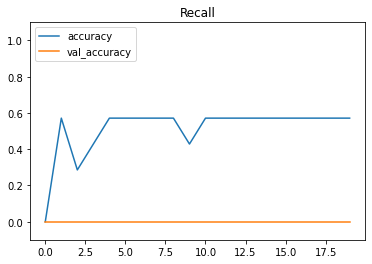

In [82]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.legend(loc='upper left')
plt.ylim(-0.1,1.1)
plt.title(f'Recall')

Text(0.5, 1.0, 'Recall')

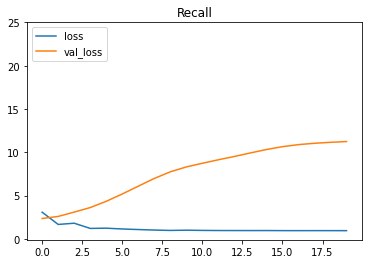

In [83]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc='upper left')
# plt.title(f'Epochs={EPOCH}')
plt.ylim(-0.1,25)
plt.title(f'Recall')

In [84]:
pred = model.predict([pad_sequences(test_data['watch_hist_time'])+ 1e-10,
                      pad_sequences(test_data['example_age'],dtype=float)+ 1e-10,
                      ])
pred.shape # (2， 11)

1/1 [==============================] - 0s 240ms/step


(1, 11)

In [89]:
N = 10
k_lst = (pred).argsort()[:,:N][0]
result=df_movie[["movie_id","title"]]
result = result.set_index(['movie_id']).sort_index()
print("result: ", result)
print("top " + str(N) + " Recommend:")

result:                                                        title
movie_id                                                   
1                                          Toy Story (1995)
2                                          GoldenEye (2011)
3                                         Four Rooms (2020)
4                                         Get Shorty (1995)
5                                            Copycat (1998)
6         Shanghai Triad (Yao a yao yao dao waipo qiao) ...
7                                     Twelve Monkeys (2018)
8                                               Babe (1995)
9                                   Dead Man Walking (1995)
10                                       Richard III (1995)
top 10 Recommend:
